# Imports

In [1]:
import random
from PIL import Image
import MySQLdb as sql
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.ndimage as ndi

from earth.utils import generateFilePathStr

/opt/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import plotly.offline as plotly
import plotly.graph_objs as go
plotly.init_notebook_mode(connected=True)

# Generate Dataset

In [4]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']

In [7]:
def get_train_dataset(n):
    grid_size = 16

    db = sql.connect(db='earthdat', host='104.199.118.158', user='root')
    cur = db.cursor()
    cur.execute(
        'SELECT lid, x_coord, y_coord, label FROM cloud_detection_kmeans2 ORDER BY RAND() LIMIT {};'.format(n)
    )
    results = cur.fetchall()
    db.close()

    dataset = np.empty((n, grid_size * grid_size * len(bands)))
    labels = np.empty((n,))
    with h5py.File(generateFilePathStr(kind='database'), 'r') as h:
        i = 0
        for lid, x, y, status in results:
            subimage = np.empty((len(bands), grid_size**2))
            for j, b in enumerate(bands):
                subimage[j] = h[lid][b][
                    x - int(grid_size / 2) : x + int(grid_size / 2),
                    y - int(grid_size / 2) : y + int(grid_size / 2)
                ].flatten()
            dataset[i] = subimage.flatten()
            labels[i] = status
            i += 1
    dataset=dataset[labels!=2]
    labels = np.vstack((
        (labels[labels!=2] == 0).astype('int'),
        (labels[labels!=2] == 1).astype('int')
    )).transpose()
    
    return dataset, labels


def get_samples_from_scene(image, n):
    grid_size = 16
    x_list = []
    y_list = []
    dataset = np.empty((n, len(bands) * grid_size ** 2))

    j = 0
    for _ in range(n):
        dim = image.shape
        subimage = np.empty((len(bands), grid_size, grid_size))
        x = random.randint(int(grid_size / 2), dim[1] - int(grid_size / 2) - 1)
        y = random.randint(int(grid_size / 2), dim[2] - int(grid_size / 2) - 1)

        for i in range(len(bands)):
            subimage[i] = image[i][
                x - int(grid_size / 2) : x + int(grid_size / 2),
                y - int(grid_size / 2) : y + int(grid_size / 2)
            ]

        dataset[j] = subimage.flatten()
        x_list.append(x)
        y_list.append(y)
        j += 1
        
    reference_df = pd.DataFrame({
        'x': x_list,
        'y': y_list
    })
    
    return dataset, reference_df

In [8]:
dataset, labels = get_train_dataset(40000)

In [12]:
trainset = dataset[:38000]
trainlabels = labels[:38000]
testset = dataset[38000:]
testlabels = labels[38000:]

# Simple Feedforward

In [13]:
class FFNN(object):
    def __init__(self, layers, activation=tf.sigmoid, input_vector=None, session=None):
        self.activation = activation
        self.layers = layers

        if input_vector is None: self.input = tf.placeholder(tf.float32, [None, layers[0]])
        else: self.input = input_vector
        if session is None: self.session = tf.InteractiveSession()
        else: self.session = session
        self.output = self.input
        self.train_targets = tf.placeholder(tf.float32, [None, layers[-1]])

        self.weights = []
        self.biases = []
        for i in range(len(self.layers) - 1):
            self.weights.append(tf.Variable(tf.random_uniform([self.layers[i], self.layers[i + 1]], -1, 1)))
            self.biases.append(tf.Variable(tf.random_uniform([self.layers[i + 1]], -1, 1)))

        for w, b in list(zip(self.weights, self.biases))[:-1]:
            self.output = self.activation(tf.matmul(self.output, w) + b)
            
        # Prevents use of activation layer
        self.output = tf.matmul(self.output, self.weights[-1]) + self.biases[-1]

        self.session.run(tf.global_variables_initializer())


    def train(self, train_in, train_out, batch_size=10, epochs=1):
        loss_val = tf.reduce_sum(
            tf.nn.softmax_cross_entropy_with_logits(logits=self.output, labels=self.train_targets)
        )
        train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss_val)

        learning_curve = []
        for i in range(epochs):
            in_batch = np.roll(train_in, -batch_size * i, 0)[:batch_size]
            out_batch = np.roll(train_out, -batch_size * i, 0)[:batch_size]
            self.session.run(train_step, feed_dict={self.input: in_batch, self.train_targets: out_batch})
            learning_curve.append(self.session.run(
                loss_val,
                feed_dict={self.input: in_batch, self.train_targets: out_batch}
            ))
        return learning_curve


    def evaluate(self, in_vector):
        return self.session.run(tf.nn.softmax(self.output), feed_dict={self.input: in_vector})

In [15]:
m = dataset.mean(axis=0)
r = abs(dataset).max()
norm_trainset = (trainset - m) / r
norm_testset = (testset - m) / r
ffnn = FFNN([2048, 4096, 4096, 4096, 4096, 4096, 2048, 512, 128, 2])

In [58]:
learning_curve = ffnn.train(norm_trainset, trainlabels, batch_size=500, epochs=1000)

In [60]:
predicted_output = ffnn.evaluate(norm_trainset)

# Train Error
print(np.sum(abs(predicted_output.argmax(axis=1) - trainlabels.argmax(axis=1))) / 38000)

# Test Error
print(np.sum(abs(ffnn.evaluate(norm_testset).argmax(axis=1) - testlabels.argmax(axis=1))) / 2000)

0.141105263158
0.1655


In [59]:
plotly.iplot([go.Scatter(
    x=np.arange(len(learning_curve)),
    y=learning_curve,
    mode='lines'
)])

# Decision Tree

In [ ]:
dtree = tree.DecisionTreeClassifier()
dtree.fit(trainset, trainlabels)

# Samples

In [61]:
def get_mini_scene(sceneid, x, y, size, h5F):
    shift_size = int(size / 2)
    vis_image = np.asarray(Image.open(generateFilePathStr(sceneid, 'preproc', 'visible')))[
        x - shift_size : x + shift_size,
        y - shift_size : y + shift_size
    ]
    
    full_image = np.empty((len(bands), size, size))
    for i, b in enumerate(bands):
        full_image[i] = h5F[sceneid][b][
            x - shift_size : x + shift_size,
            y - shift_size : y + shift_size
        ]
    
    return vis_image, full_image

In [62]:
with h5py.File(generateFilePathStr(kind = 'database'), 'r') as h5F:
    vis_im, full_im = get_mini_scene('LC80410322013165LGN00', 1800, 2400, 1024, h5F)
map_image = np.zeros((1024, 1024), dtype='uint8')

In [54]:
for run in range(5):
    sampleset, reference_df = get_samples_from_scene(full_im, 10000)
    sample_pred = dtree.evaluate(norm_sampleset)[:, 1]

    for i in range(sample_pred.shape[0]):
        x = reference_df['x'][i]
        y = reference_df['y'][i]
        map_image[x-1:x+1, y-1:y+1] = int((1 - sample_pred[i]) * 255)

In [63]:
for run in range(5):
    sampleset, reference_df = get_samples_from_scene(full_im, 10000)

    norm_sampleset = (sampleset - m) / r
    sample_pred = ffnn.evaluate(norm_sampleset)[:, 1]

    for i in range(sample_pred.shape[0]):
        x = reference_df['x'][i]
        y = reference_df['y'][i]
        map_image[x-1:x+1, y-1:y+1] = int((1 - sample_pred[i]) * 255)

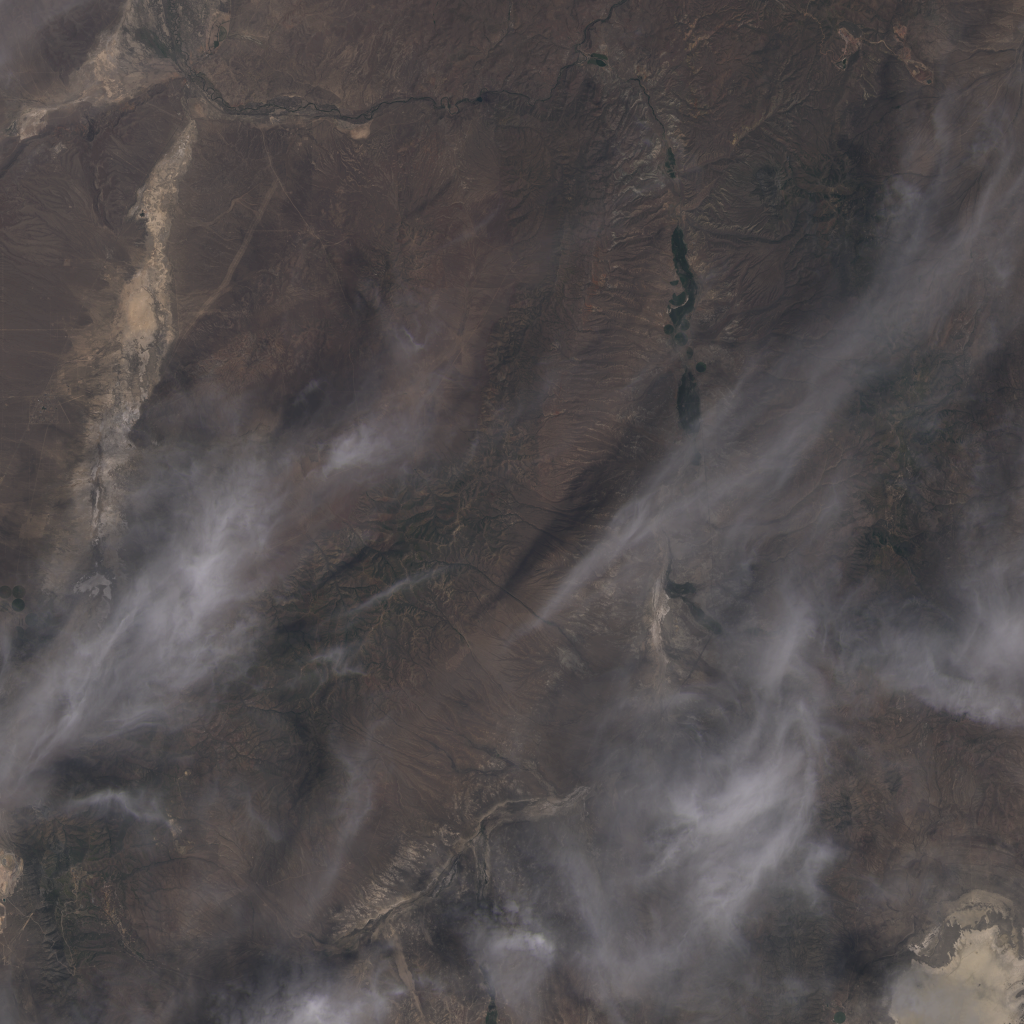

In [55]:
Image.fromarray(vis_im)

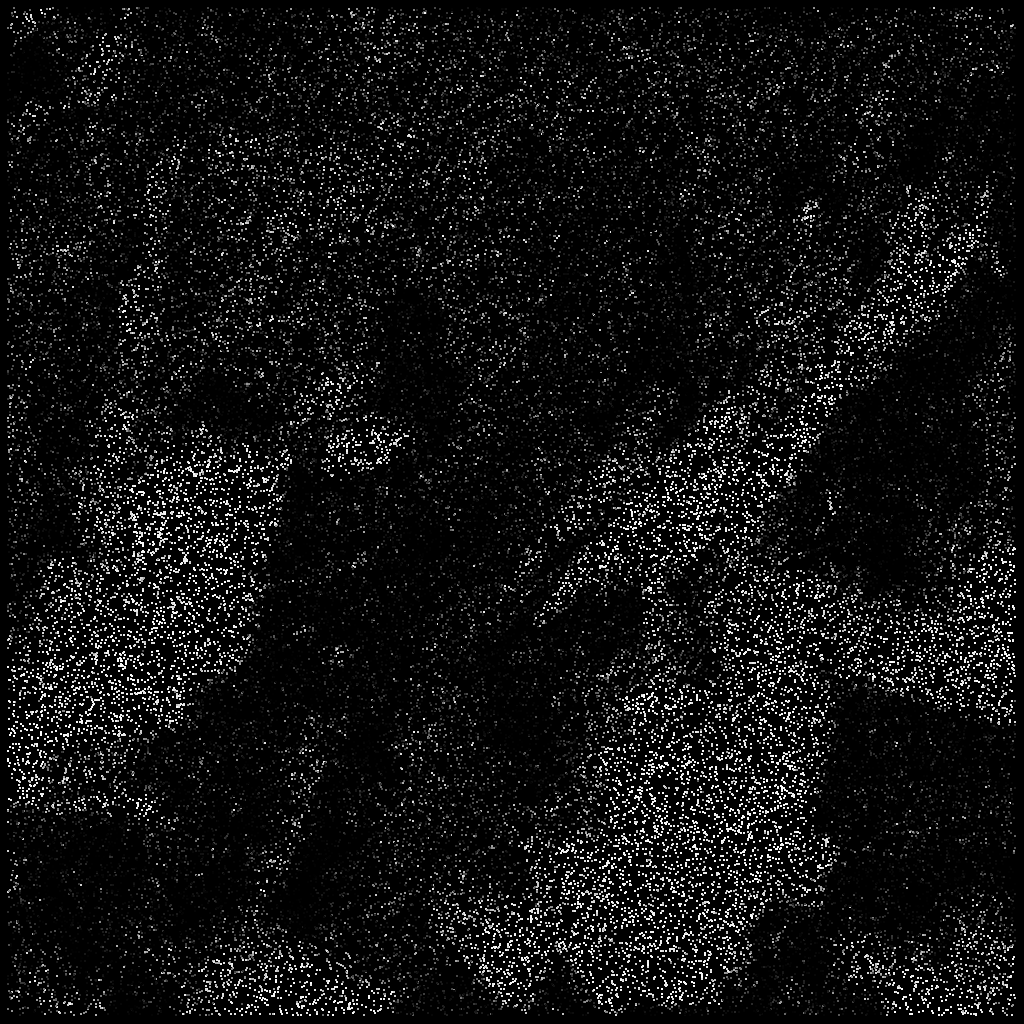

In [64]:
Image.fromarray(map_image)